In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, statistics, CoxPHFitter
import numpy as np
from lifelines.statistics import logrank_test
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance



In [6]:
import sys
print(sys.executable)



/Users/binalpatel/miniconda3/envs/surv_env/bin/python


In [7]:
# Load dataset
file_path = "/Users/binalpatel/Desktop/Machine learning/Assignment-4/Data/RADCURE_Clinical_v04_20241219.xlsx"
df = pd.read_excel(file_path)

# Print column names 
print("Columns in dataset:", df.columns.tolist())

Columns in dataset: ['patient_id', 'Age', 'Sex', 'ECOG PS', 'Smoking PY', 'Smoking Status', 'Ds Site', 'Subsite', 'T', 'N', 'M ', 'Stage', 'Path', 'HPV', 'Tx Modality', 'Chemo', 'RT Start', 'Dose', 'Fx', 'Last FU', 'Status', 'Length FU', 'Date of Death', 'Cause of Death', 'Local', 'Date Local', 'Regional', 'Date Regional', 'Distant', 'Date Distant', '2nd Ca', 'Date 2nd Ca', 'RADCURE-challenge', 'ContrastEnhanced']


In [8]:
# Prepare survival data
# Create event indicator: Status= "dead" and "ALive"

df["event"] = df["Status"].map({"Alive": 0, "Dead": 1})


# Use 'Length FU' as the survival time
df['time'] = df['Length FU']

# Create a grouping variable based on age 
median_age = df['Age'].median()
df['age_group'] = np.where(df['Age'] >= median_age, 'Older', 'Younger')


In [9]:
# Check how many rows have event=0 vs. event=1
print("Event column value counts:")
print(df["event"].value_counts(dropna=False))

# Inspect some rows to confirm event/time logic
# Adjust 'head(10)' to see more or fewer rows as needed
print("\nSample rows of interest:")
print(df[["Status", "Length FU", "event"]].head(10))

print(df["Status"].unique())


Event column value counts:
event
0    2288
1    1058
Name: count, dtype: int64

Sample rows of interest:
  Status  Length FU  event
0   Dead   1.317808      1
1   Dead   1.520548      1
2  Alive   2.126027      0
3  Alive   5.791781      0
4  Alive   9.512329      0
5  Alive   5.372603      0
6  Alive  11.876712      0
7   Dead   4.189041      1
8   Dead   1.712329      1
9   Dead   8.991781      1
['Dead' 'Alive']


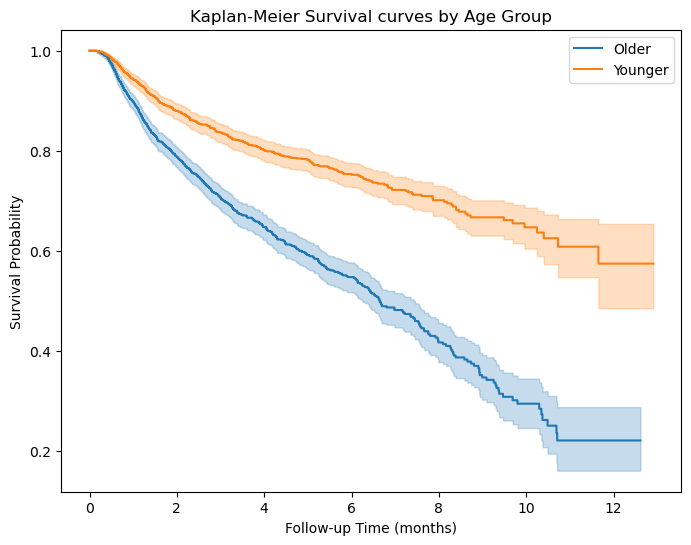

Log-rank test p-value (Older vs Younger): 1.99e-36


In [10]:
# 1. Kaplan-Meier Analysis

kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))
for group_name, group_df in df.groupby('age_group'):
    kmf.fit(group_df['time'], group_df['event'], label=group_name)
    kmf.plot_survival_function(ci_show=True)
plt.title("Kaplan-Meier Survival curves by Age Group")
plt.xlabel("Follow-up Time (months)")
plt.ylabel("Survival Probability")
plt.show()

# Conduct log-rank test between the two age groups
group_older = df[df['age_group'] == 'Older']
group_younger = df[df['age_group'] == 'Younger']
lr_results = logrank_test(group_older['time'], group_younger['time'],
                          event_observed_A=group_older['event'],
                          event_observed_B=group_younger['event'])
print(f"Log-rank test p-value (Older vs Younger): {lr_results.p_value:.2e}")


<lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 3346
number of events observed = 1058
   partial log-likelihood = -7726.42
         time fit was run = 2025-03-15 00:21:30 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                           
Age                           0.04       1.04       0.00             0.03             0.04                 1.03                 1.04
Stage_I                      -0.40       0.67       0.26            -0.91             0.11                 0.40                 1.12
Stage_IB                    -17.08       0.00   21664.36        -42478.45         42444.30                 0.00                  inf
Stage_II                     -0.12       0.89       0.25            -0.62             0.38                 0.54                 1.46
Stage_IIA                   -11.39       0.00     581.89         -1151.86          1129.09                 0.00                  inf
Stage_IIB                     1.96       7.08       1.03            -0.06             3.97                 0.94                53.19
Stage_III                     0.26       1.29       0.25            -0.23             0.74                 0.80                 2.10
Stage_IIIA                    2.60      13.45       0.75             1.13             4.07                 3.10                58.29
Stage_IIIC                    2.53      12.59       0.75             1.07             4.00                 2.91                54.37
Stage_IV                      0.95       2.60       0.45             0.08             1.83                 1.08                 6.24
Stage_IVA                     0.58       1.78       0.24             0.10             1.05                 1.11                 2.86
Stage_IVB                     1.38       3.96       0.25             0.88             1.87                 2.42                 6.48
Stage_IVC                   -12.89       0.00    1460.50         -2875.42          2849.64                 0.00                  inf
Stage_X                       1.68       5.35       0.55             0.59             2.76                 1.81                15.84
Tx Modality_ChemoRT         -12.12       0.00     976.41         -1925.85          1901.62                 0.00                  inf
Tx Modality_Postop RT alone   1.95       6.99       0.71             0.55             3.34                 1.73                28.25
Tx Modality_RT + EGFRI        0.52       1.68       0.18             0.16             0.87                 1.17                 2.40
Tx Modality_RT alone          0.74       2.10       0.08             0.59             0.90                 1.80                 2.46

                              cmp to     z      p   -log2(p)
covariate                                                   
Age                             0.00 11.44 <0.005      98.28
Stage_I                         0.00 -1.54   0.12       3.00
Stage_IB                        0.00 -0.00   1.00       0.00
Stage_II                        0.00 -0.48   0.63       0.66
Stage_IIA                       0.00 -0.02   0.98       0.02
Stage_IIB                       0.00  1.90   0.06       4.13
Stage_III                       0.00  1.04   0.30       1.73
Stage_IIIA                      0.00  3.47 <0.005      10.93
Stage_IIIC                      0.00  3.39 <0.005      10.50
Stage_IV                        0.00  2.13   0.03       4.93
Stage_IVA                       0.00  2.38   0.02       5.85
Stage_IVB                       0.00  5.47 <0.005      24.40
Stage_IVC                       0.00 -0.01   0.99       0.01
Stage_X                         0.00  3.03 <0.005       8.68
T


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3346 total observations, 2288 right-censored observations>
         test_name = proportional_hazard_test

---
                                  test_statistic      p  -log2(p)
Age                         km             12.88 <0.005     11.56
                            rank           12.10 <0.005     10.95
Stage_I                     km              6.59   0.01      6.61
                            rank            3.74   0.05      4.23
Stage_IB                    km              0.00   1.00      0.00
                            rank            0.00   1.00      0.00
Stage_II                    km              3.48   0.06      4.01
                            rank            2.00   0.16      2.67
Stage_IIA                   km              0.00   1.00      0.00
                            rank            0.00   1.00      0.00
Stage_IIB                   km              0.06   0.81      0.31
                            rank            0.07   0.79      0.34
Stage_III                   km              0.07   0.80      0.33
                            rank            0.02   0.89      0.17
Stage_IIIA                  km              0.17   0.68      0.57
                            rank            0.22   0.64      0.64
Stage_IIIC                  km              0.26   0.61      0.72
                            rank            0.28   0.59      0.75
Stage_IV                    km              0.00   0.97      0.04
                            rank            0.02   0.88      0.19
Stage_IVA                   km              0.00   0.99      0.02
                            rank            0.26   0.61      0.72
Stage_IVB                   km              1.20   0.27      1.87
                            rank            3.25   0.07      3.81
Stage_IVC                   km              0.00   1.00      0.00
                            rank            0.00   1.00      0.00
Stage_X                     km              0.13   0.72      0.48
                            rank            0.26   0.61      0.72
Tx Modality_ChemoRT         km              0.00   1.00      0.00
                            rank            0.00   1.00      0.00
Tx Modality_Postop RT alone km              0.50   0.48      1.06
                            rank            0.51   0.47      1.08
Tx Modality_RT + EGFRI      km              0.44   0.51      0.98
                            rank            0.61   0.44      1.20
Tx Modality_RT alone        km              0.00   0.99      0.02
                            rank            0.46   0.50      1.00



1. Variable 'Age' failed the non-proportional test: p-value is 0.0003.

   Advice 1: the functional form of the variable 'Age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Age' using pd.cut, and then specify it in `strata=['Age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


2. Variable 'Stage_I' failed the non-proportional test: p-value is 0.0102.

   Advice: with so few unique values (only 2), you can include `strata=['Stage_I', ...]` in the call
in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take 

[[<Axes: xlabel='rank-transformed time\n(p=0.0005)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0003)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0531)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0102)'>],
 [<Axes: xlabel='rank-transformed time\n(p=1.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=1.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1568)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0619)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.9993)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9994)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7916)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8084)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8904)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7952)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.6404)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6759)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5944)'>,
  <Axes: xlabel='km-transformed time\n(p=0.6079)'>],
 [<Axes: xlabel='rank-transformed tim

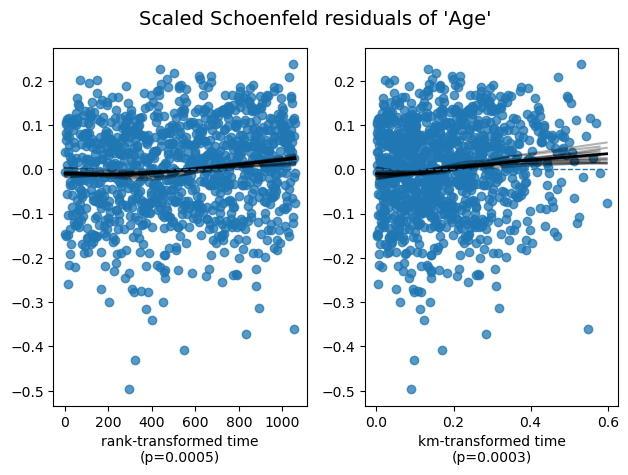

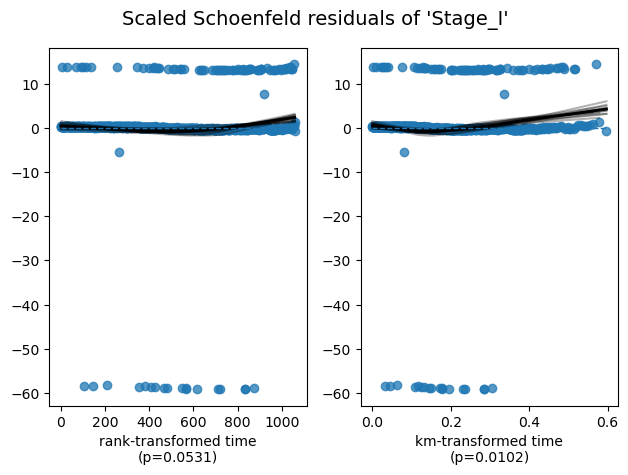

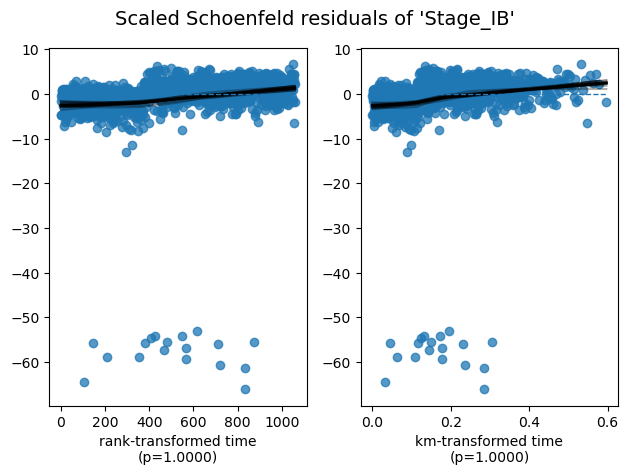

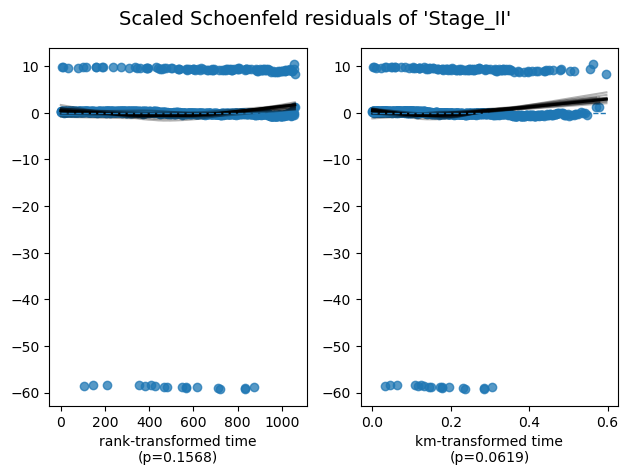

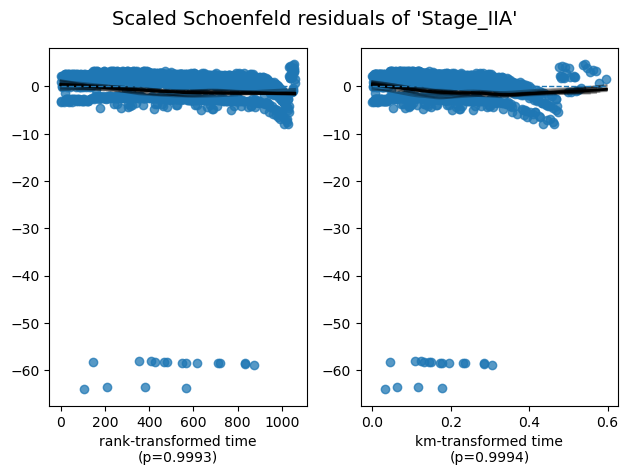

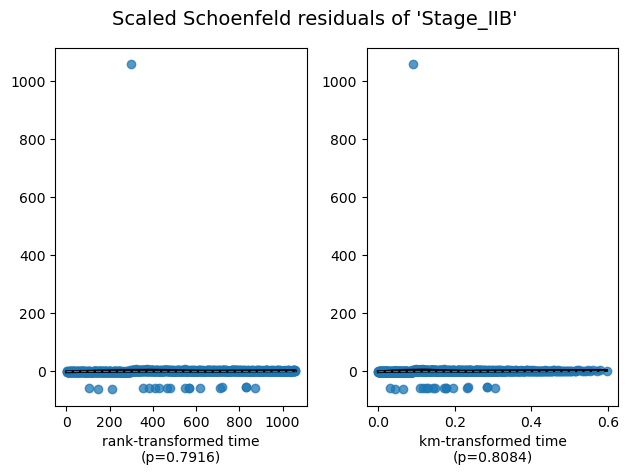

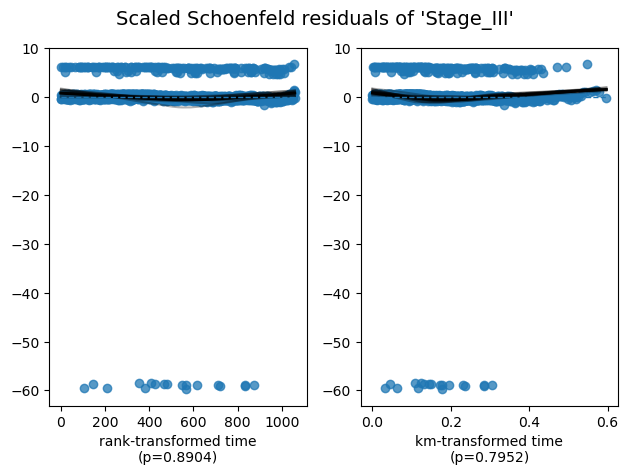

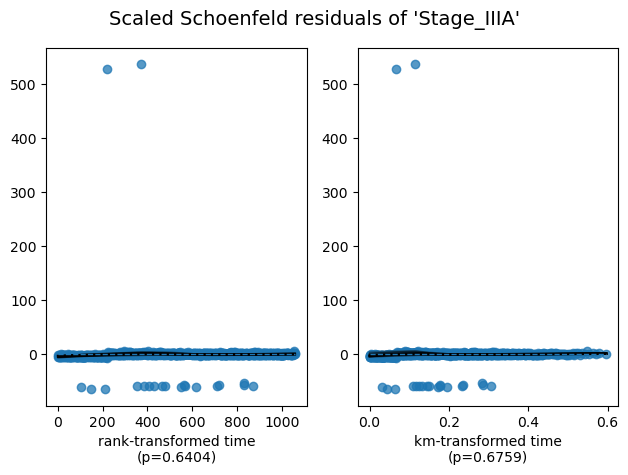

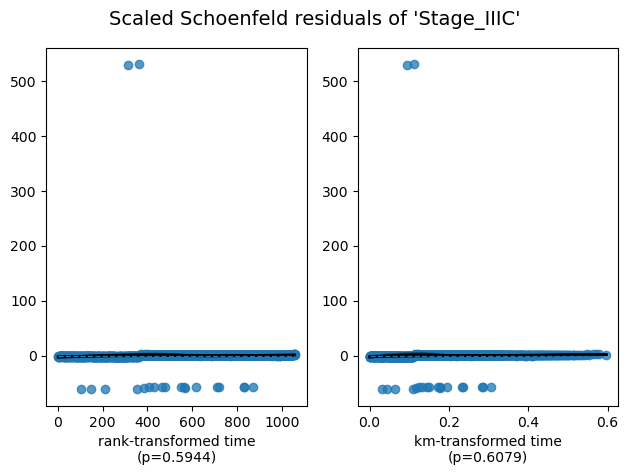

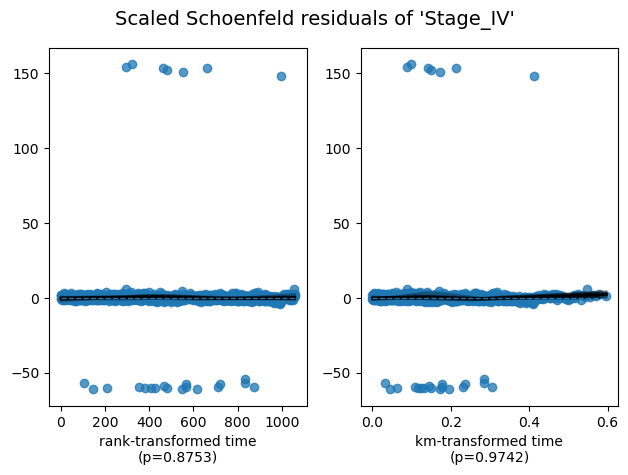

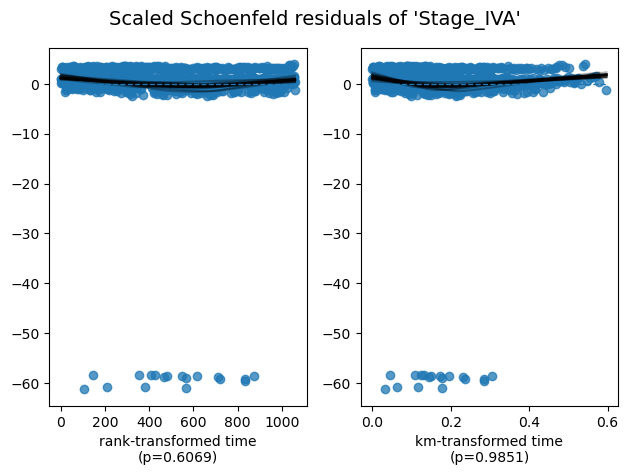

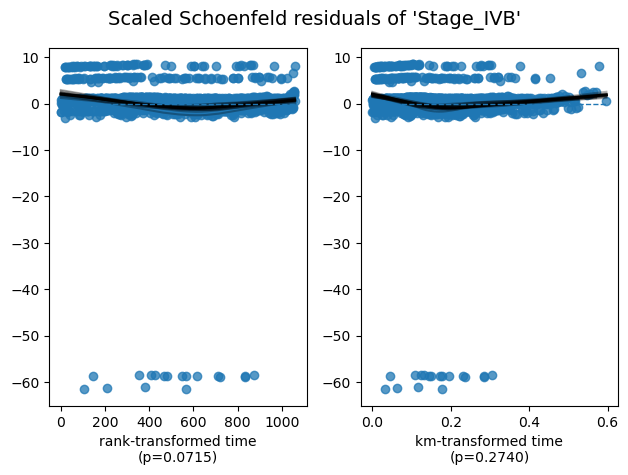

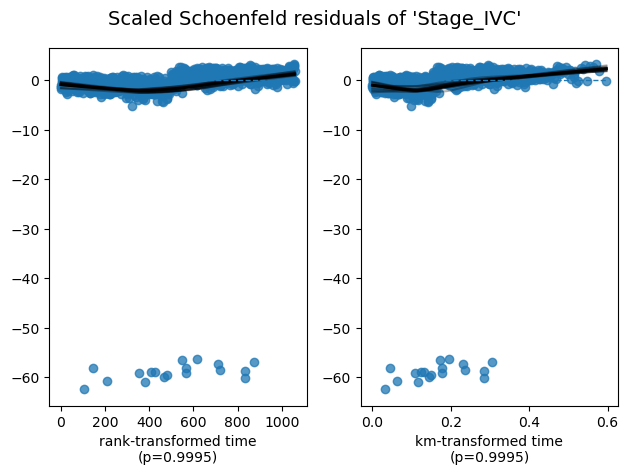

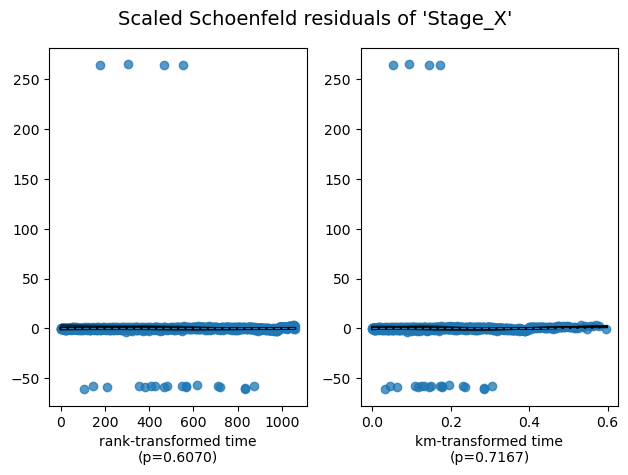

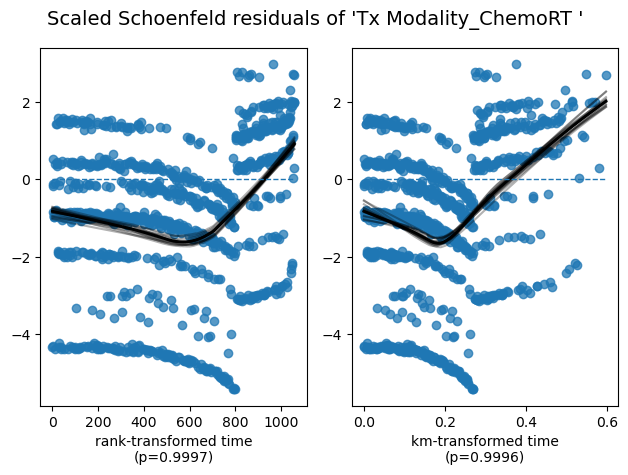

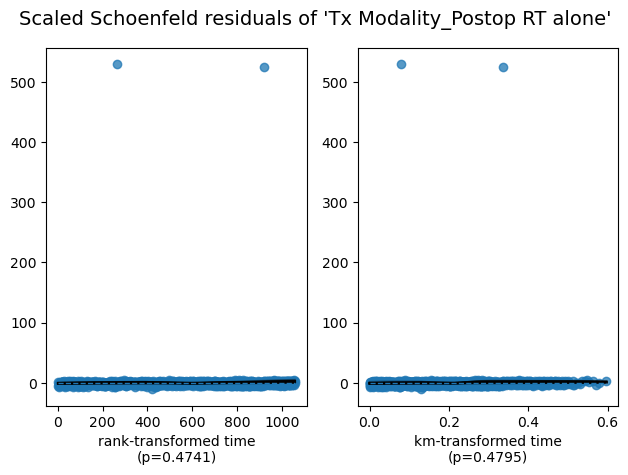

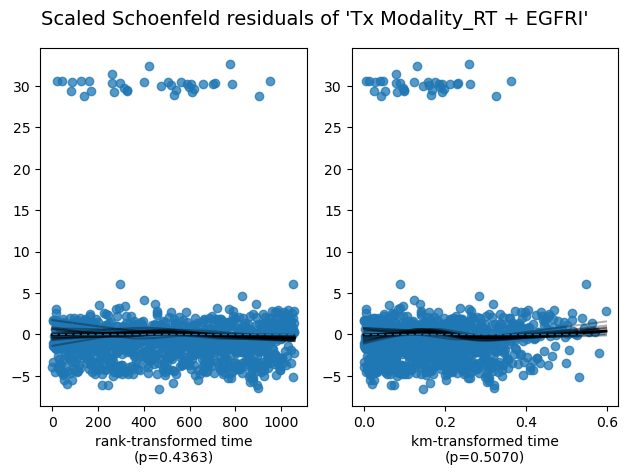

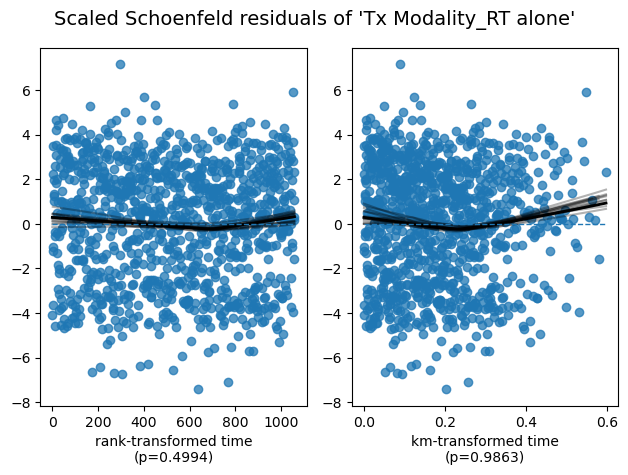

In [12]:
# 2. Cox Proportional Hazards Regression (Age, Stage and Treatment Modality)

# Convert categorical columns to category dtype
df['Stage'] = df['Stage'].astype('category')
df['Tx Modality'] = df['Tx Modality'].astype('category')

# Create dummy variables for categorical predictors
df_cox = pd.get_dummies(df[['time', 'event', 'Age', 'Stage', 'Tx Modality']], drop_first=True)

# Fit the Cox model
cph = CoxPHFitter()
cph.fit(df_cox, duration_col='time', event_col='event')
cph.print_summary()

# Validate the proportional hazards assumption
cph.check_assumptions(df_cox, show_plots=True)


Permutation-based Variable Importance for RSF:
                        Feature  Importance
0                           Age    0.107482
17         Tx Modality_RT alone    0.045699
11                    Stage_IVB    0.037191
10                    Stage_IVA    0.022620
1                       Stage_I    0.017942
6                     Stage_III    0.014359
3                      Stage_II    0.012352
16       Tx Modality_RT + EGFRI    0.001209
2                      Stage_IB    0.000000
4                     Stage_IIA    0.000000
5                     Stage_IIB    0.000000
7                    Stage_IIIA    0.000000
8                    Stage_IIIC    0.000000
12                    Stage_IVC    0.000000
13                      Stage_X    0.000000
14         Tx Modality_ChemoRT     0.000000
15  Tx Modality_Postop RT alone    0.000000
9                      Stage_IV    0.000000
RSF Concordance Index: 0.72
Cox Proportional Hazards Concordance Index: 0.70


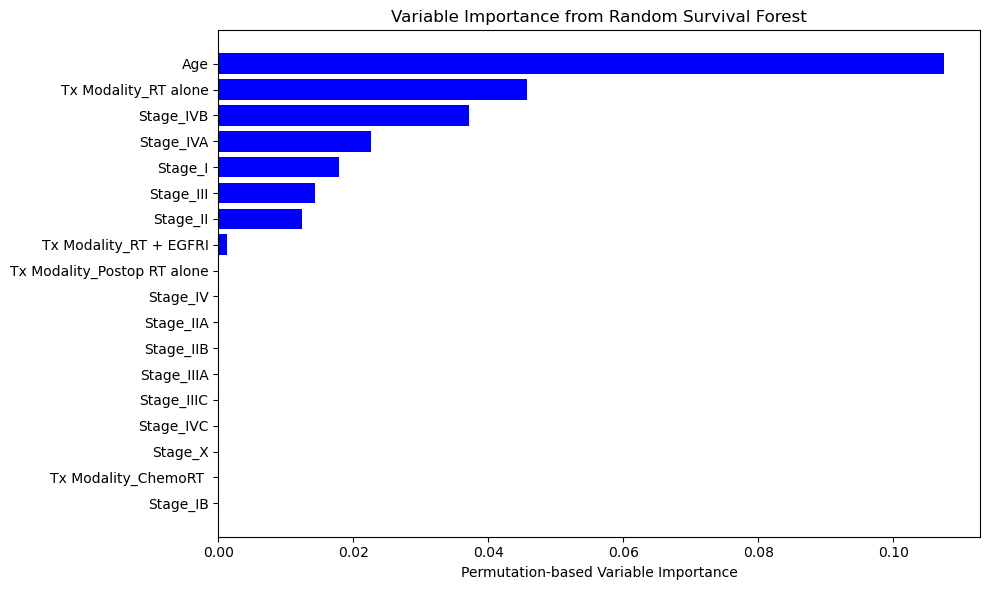

In [18]:
# 3. Random Survival Forests (RSF)

# Create dummy variables for categorical predictors for RSF
X = pd.get_dummies(df[['Age', 'Stage', 'Tx Modality']], drop_first=True)

# Create a structured array for survival data using sksurv
y = Surv.from_dataframe("event", "time", df)

# Random survival forest model

# Build the RSF model
rsf = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=15,
    random_state=42
)
rsf.fit(X, y)

# Variable importance analysis

# --- Permutation-based Variable Importance ---
perm_importance = permutation_importance(rsf, X, y, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

print("Permutation-based Variable Importance for RSF:")
print(importance_df)

# --- Concordance Index Comparison ---
rsf_c_index = rsf.score(X, y)
cox_c_index = cph.concordance_index_  # Assuming your Cox model is already fitted and stored in cph


print(f"RSF Concordance Index: {rsf_c_index:.2f}")
print(f"Cox Proportional Hazards Concordance Index: {cox_c_index:.2f}")

# Sort importance values for plotting (lowest at the bottom)
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=True)

plt.figure(figsize=(10,6))
plt.barh(importance_df_sorted["Feature"], importance_df_sorted["Importance"], color='blue')
plt.xlabel("Permutation-based Variable Importance")
plt.title("Variable Importance from Random Survival Forest")
plt.tight_layout()
plt.show()